# **3D Heart Segmentation**: Preprocessing & Insights

Deep learning models for medical imaging require consistent, high-quality input data. Raw MRI scans often vary in voxel spacing, intensity distribution, and noise levels, making preprocessing a crucial step before training segmentation models.

This study investigates:

* Patients metadata correlations for better understanding of connection between heart conditions and other parameters.
* Image metrics of the MRI scans, showing the problematic stats that need to be treaten before feeding the deep learning model for segmentation prediction.
* preprocessing techniques for better and consist image patterns.

By analyzing real MRI scans and systematically applying preprocessing techniques, this research builds a robust pipeline for training high-accuracy heart segmentation models.



## Setup & Imports

In [1]:
!pip install -q SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 MB 6.8 MB/s eta 0:00:00


In [2]:
# System & OS
import os
import sys
import json
import random
import re

# Google Drive (Colab)
from google.colab import drive

# Math & Stats
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter, zoom, shift, label, center_of_mass
from scipy import ndimage

# Image Processing
import nibabel as nib
import SimpleITK as sitk

# Deep Learning (PyTorch)
import torch
import torchvision.models.video as models

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import plotly.graph_objects as go

In [3]:
color_palette = ["#FF4C4C",
                 "#FF7373",
                 "#FF9999",
                 "#FFB6C1",
                 "#6600CC",
                 "#9900FF",
                 "#4C00FF",
                 "#0066FF",
                 "#FFFFFF"]

drive.mount('/content/drive')

BASE_PATH = "/content/drive/MyDrive/Projects/Heart Reconstruction/dataset/"
TRAIN_IMAGES_PATH = os.path.join(BASE_PATH, 'train/images')
TRAIN_MASKS_PATH = os.path.join(BASE_PATH, 'train/masks')
VAL_IMAGES_PATH = os.path.join(BASE_PATH, 'val/images')
VAL_MASKS_PATH = os.path.join(BASE_PATH, 'val/masks')
METADATA_PATH = os.path.join(BASE_PATH, 'metadata.json')
SCAN_METRICS_PATH = os.path.join(BASE_PATH, 'scan_metadata.json')

Mounted at /content/drive



### **What is NIfTI?**  
NIfTI is a **medical imaging format** for 3D MRI & CT scans in a single file, preserving the **full volumetric structure** of the scan. It is widely used in medical AI for **segmentation**, **disease detection**, and **3D reconstruction**.

Each NIfTI scan consists of multiple **2D slices** stacked together to form a 3D volume. **More slices = a better 3D heart model, but at the cost of higher computational load**.

### **Dataset Selection**  
The dataset from the **[Human Heart Project](https://humanheart-project.creatis.insa-lyon.fr/database/)** contains multiple NIfTI files per patient:  

🟢 Chosen: ``frame01.nii.gz`` – A 3D heart scan with expert-labeled segmentation masks.

🔴 Skipped: ``4d.nii.gz`` - A 4D scans (too large, redundant for static 3D reconstruction).

**Why?** Efficient, precise, and ideal for training AI models in heart segmentation.

# **1 - Load Dataset & Metadata**

The dataset consists of **volumetric MRI scans** with corresponding **segmentation masks**. Metadata files including patient data and image feature statistics.


In [4]:
def get_patient_id(image_path):
    patient_id = os.path.basename(image_path).split("_")[0]
    patient_id = re.search(r"(patient\d+)", patient_id).group(1)
    return patient_id

In [5]:
def get_image_mask_pairs(image_dir, mask_dir):
    image_paths = sorted(glob.glob(os.path.join(image_dir, "*.nii.gz")))
    mask_paths = [img.replace("images", "masks").replace(".nii.gz", "_mask.nii.gz") for img in image_paths]
    assert all(os.path.exists(m) for m in mask_paths), "🚨 Some masks are missing!"
    return image_paths, mask_paths

In [6]:
def load_file(file_path):
    with open(file_path, "r") as file:
        content = json.load(file)
    return content

In [7]:
train_image_paths, train_mask_paths = get_image_mask_pairs(TRAIN_IMAGES_PATH, TRAIN_MASKS_PATH)
val_image_paths, val_mask_paths = get_image_mask_pairs(VAL_IMAGES_PATH, VAL_MASKS_PATH)
print(f"✅ Found {len(train_image_paths)} training cases & {len(val_image_paths)} validation cases.")

✅ Found 99 training cases & 50 validation cases.


In [8]:
metadata = load_file(METADATA_PATH)
scan_metrics = load_file(SCAN_METRICS_PATH)

In [9]:
def flatten_metadata(metadata):
    flat_data = []
    for patient_id, details in metadata.items():
        details["Patient ID"] = patient_id
        details = details.copy()
        flat_data.append(details)
    return pd.DataFrame(flat_data)

# **2 - Dataset Investigaton**

Analyzing Patients Metadata and MRI Scans Metrics for suiting processing methods.

### **2.1 - Patients Metadata**

Exploring potential correlations between patient parameters and heart conditions to refine MRI selection and segmentation.

**Key Findings**:

* **Height vs. Weight by Condition** - Statistical analysis (ANOVA, Kruskal-Wallis) shows **no significant link** between weight and heart conditions.
* **Systolic Distribution by Condition** - ESV patterns suggest different conditions affect heart contraction differently (e.g., DCM shows a wide range, HCM a narrow range).
* **Number of Frames Distribution** - Most scans contain ~30 frames, indicating a standard imaging protocol.

In [10]:
df_train = flatten_metadata(metadata['train'])

#### **2.1.1 - Height vs. Weight Distribution by Heart Condition Group**


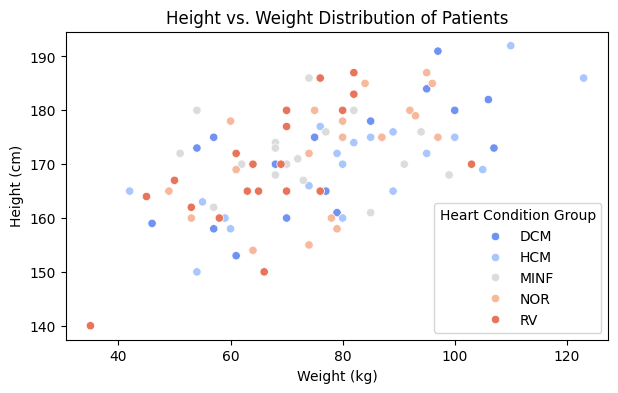

In [11]:
plt.figure(figsize=(7, 4))
sns.scatterplot(x=df_train["Weight"].astype(float), y=df_train["Height"].astype(float), hue=df_train["Group"], palette="coolwarm")
plt.title("Height vs. Weight Distribution of Patients")
plt.xlabel("Weight (kg)")
plt.ylabel("Height (cm)")
plt.legend(title="Heart Condition Group")
plt.show()

#### **2.1.2 - Systolic Distribution by Heart Condition Group**

<ipython-input-12-4d5c27997c24>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Group", y=df_train["ES"].astype(int), data=df_train, palette="coolwarm", inner="quartile")


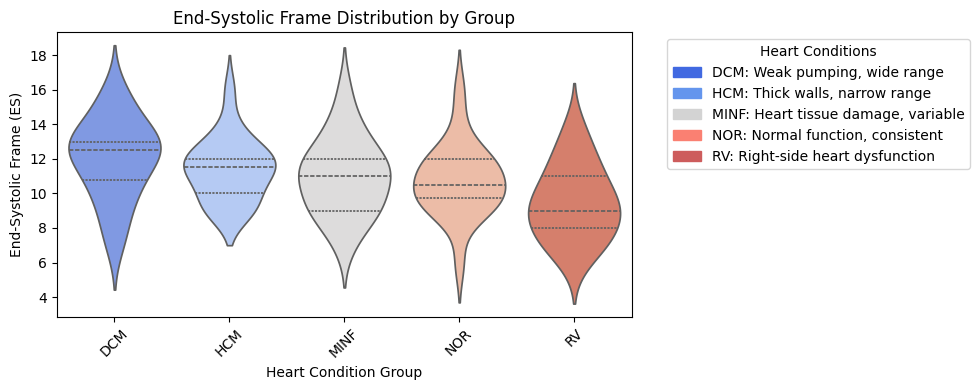

In [12]:
legend_patches = [
    mpatches.Patch(color="royalblue", label="DCM: Weak pumping, wide range"),
    mpatches.Patch(color="cornflowerblue", label="HCM: Thick walls, narrow range"),
    mpatches.Patch(color="lightgray", label="MINF: Heart tissue damage, variable"),
    mpatches.Patch(color="salmon", label="NOR: Normal function, consistent"),
    mpatches.Patch(color="indianred", label="RV: Right-side heart dysfunction"),
]

plt.figure(figsize=(10, 4))
sns.violinplot(x="Group", y=df_train["ES"].astype(int), data=df_train, palette="coolwarm", inner="quartile")
plt.title("End-Systolic Frame Distribution by Group")
plt.xlabel("Heart Condition Group")
plt.ylabel("End-Systolic Frame (ES)")
plt.xticks(rotation=45)
plt.legend(handles=legend_patches, title="Heart Conditions", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### **2.1.3 - Distribution of Numebr Of Frames**

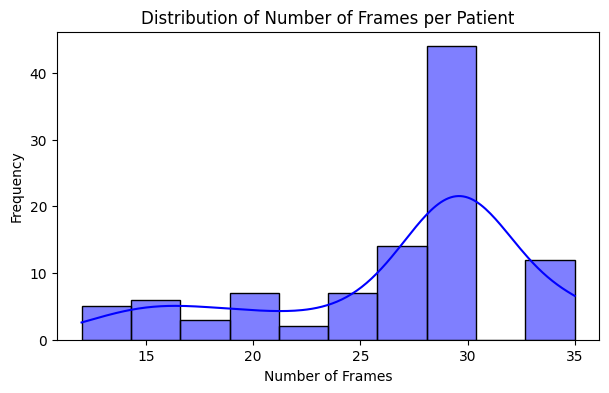

In [13]:
plt.figure(figsize=(7, 4))
sns.histplot(df_train["NbFrame"].astype(int), bins=10, kde=True, color="blue")
plt.title("Distribution of Number of Frames per Patient")
plt.xlabel("Number of Frames")
plt.ylabel("Frequency")
plt.show()

### **2.2 - MRI Scans Metrics**
This section analyzes MRI intensity distribution and voxel dimensions to detect contrast issues and ensure uniform and standard data.

* **Intensity Distribution** - Identifies contrast inconsistencies, artifacts, and poor-quality scans, guiding normalization needs.
* **Mean vs. Std Intensity** - Higher standard deviation indicates greater contrast, meaning brighter scans tend to have more intensity variation.
* **Voxel Dimensions** - 100% of scans are anisotropic, meaning inconsistent slice thickness may distort 3D models.
  * **Solution** - Normalize voxel scales and resample to isotropic spacing, ensuring consistent image quality for stable model training.

In [14]:
image_metrics_df = flatten_metadata(scan_metrics['train'])

#### **2.2.1 - Intensity Distribution**


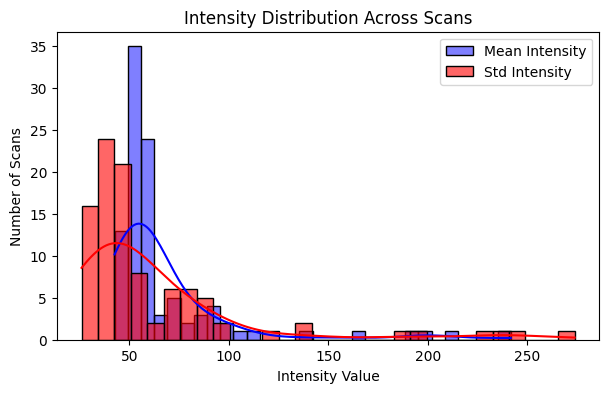

In [15]:
plt.figure(figsize=(7, 4))
sns.histplot(image_metrics_df["Mean Intensity"], bins=30, kde=True, color='blue', label="Mean Intensity")
sns.histplot(image_metrics_df["Std Intensity"], bins=30, kde=True, color='red', label="Std Intensity", alpha=0.6)
plt.title("Intensity Distribution Across Scans")
plt.xlabel("Intensity Value")
plt.ylabel("Number of Scans")
plt.legend()
plt.show()

#### **2.2.2 - Mean Intensity vs. Standard Deviation**

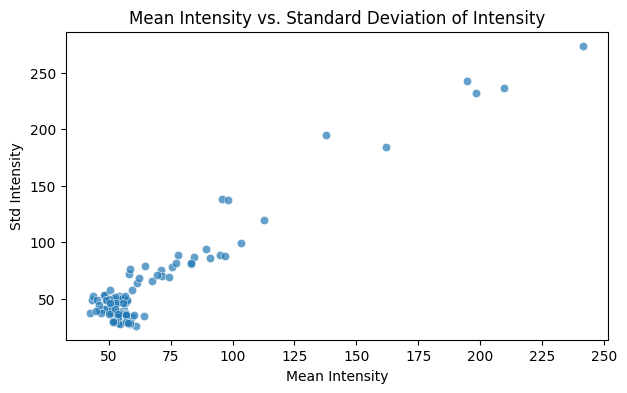

In [16]:
plt.figure(figsize=(7, 4))
sns.scatterplot(x=image_metrics_df["Mean Intensity"], y=image_metrics_df["Std Intensity"], alpha=0.7)
plt.title("Mean Intensity vs. Standard Deviation of Intensity")
plt.xlabel("Mean Intensity")
plt.ylabel("Std Intensity")
plt.show()

#### **2.2.3 - Analyze Voxel Dimensions**

Standard Deviation of Voxel Spacing:
X-Dimension: 0.1835
Y-Dimension: 0.1835
Z-Dimension: 1.6715


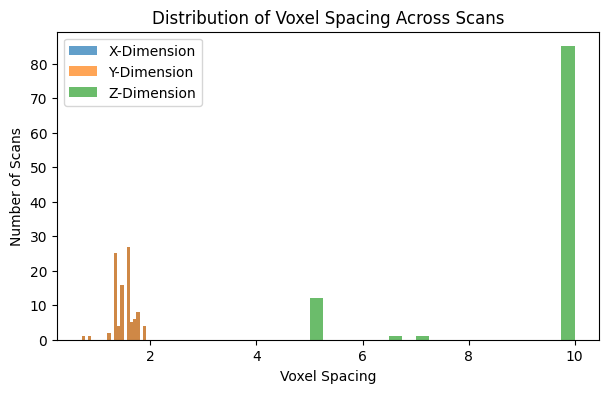

In [17]:
voxel_spacing = np.array(image_metrics_df["Voxel Spacing"].tolist())
voxel_std = np.std(voxel_spacing, axis=0)

print(f"Standard Deviation of Voxel Spacing:")
print(f"X-Dimension: {voxel_std[0]:.4f}")
print(f"Y-Dimension: {voxel_std[1]:.4f}")
print(f"Z-Dimension: {voxel_std[2]:.4f}")

plt.figure(figsize=(7, 4))
plt.hist(voxel_spacing[:, 0], bins=20, alpha=0.7, label="X-Dimension")
plt.hist(voxel_spacing[:, 1], bins=20, alpha=0.7, label="Y-Dimension")
plt.hist(voxel_spacing[:, 2], bins=20, alpha=0.7, label="Z-Dimension")
plt.xlabel("Voxel Spacing")
plt.ylabel("Number of Scans")
plt.title("Distribution of Voxel Spacing Across Scans")
plt.legend()
plt.show()

#### **2.2.4 - Bias Field Detection**

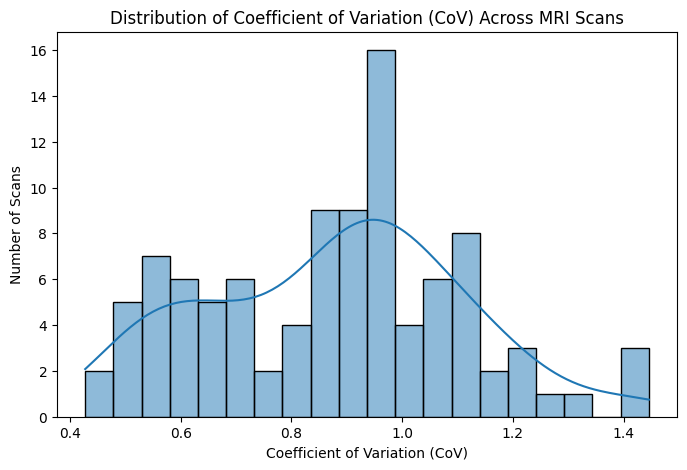

In [18]:
# Compute CoV values as a NumPy array
cov_values = np.array(image_metrics_df["Std Intensity"]) / np.array(image_metrics_df["Mean Intensity"])

# Visualize the distribution of CoV values
plt.figure(figsize=(8, 5))
sns.histplot(cov_values, bins=20, kde=True)
plt.xlabel("Coefficient of Variation (CoV)")
plt.ylabel("Number of Scans")
plt.title("Distribution of Coefficient of Variation (CoV) Across MRI Scans")
plt.show()

#### **Noise Level Detection**

## **2.3 - Is There a Connection Between Patient Conditions and MRI Scan Distortions?**

Later in this section, the data reveals there is **no strong correlation between patient conditions and MRI scan distortions**.

 The only noticeable correlations are in expected properties, such as voxel spacing, shape dimensions, and intensity levels.

#### Merge and Clean the two dataframes

In [19]:
df_train.index.name = "Patient ID"
image_metrics_df.index.name = "Patient ID"
merged_df = df_train.merge(image_metrics_df, left_index=True, right_index=True, how="inner")

In [20]:
merged_df_cleaned = merged_df.drop(columns=["Patient ID", "Patient ID_x", "Patient ID_y"], errors="ignore")
merged_df_cleaned["Group"] = merged_df_cleaned["Group"].astype("category").cat.codes

In [21]:
# Split "Voxel Spacing" into separate X, Y, Z columns
voxel_spacing_df = merged_df_cleaned["Voxel Spacing"].apply(pd.Series)
voxel_spacing_df.columns = ["Voxel Spacing X", "Voxel Spacing Y", "Voxel Spacing Z"]

# Split "Shape" into separate columns for image dimensions
shape_df = merged_df_cleaned["Shape"].apply(pd.Series)
shape_df.columns = ["Shape X", "Shape Y", "Shape Z"]

# Merge the split columns back into the main DataFrame and drop the original list columns
merged_df_cleaned = pd.concat([merged_df_cleaned, voxel_spacing_df, shape_df], axis=1)
merged_df_cleaned = merged_df_cleaned.drop(columns=["Voxel Spacing", "Shape"], errors="ignore")

#### Visualize Correlations

In [22]:
correlation_matrix = merged_df_cleaned.corr()

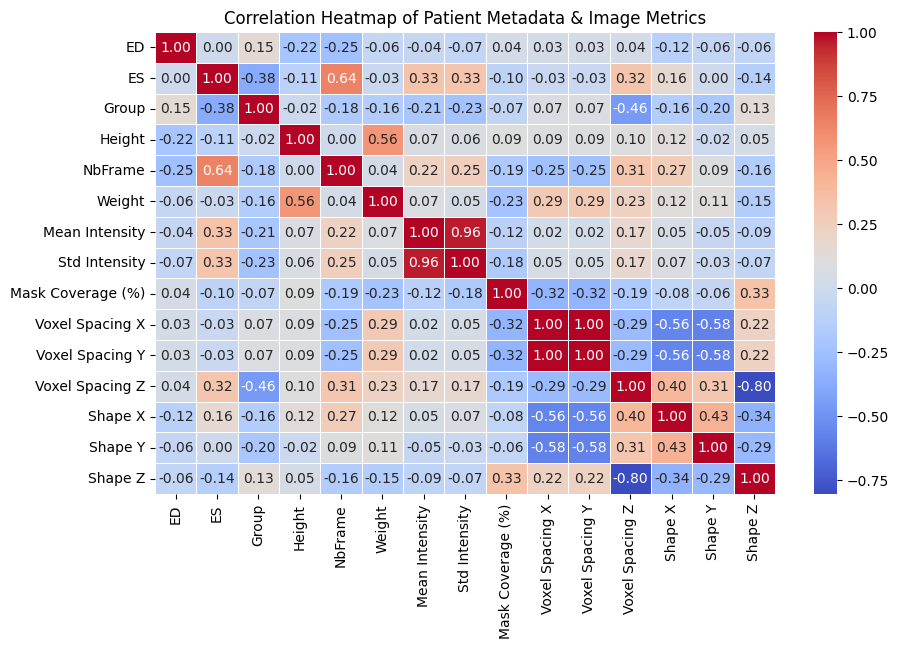

In [23]:
# Plot a simple heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Patient Metadata & Image Metrics")
plt.show()

# **3 - Processing Techniques**
This demonstrates how the selected MRI scan undergoes multiple processing techniques to prepare it for AI model training. From bias correction to resampling, normalization, and alignment, each step ensures that the scan is optimized for segmentation tasks

#### Visualization functions

In [24]:
def plot_intensity_histograms(original_scan, normalized_scan):
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))

    # Histogram of original scan
    ax[0].hist(original_scan.flatten(), bins=100, color='red', alpha=0.6)
    ax[0].set_title("Original Intensity Distribution")
    ax[0].set_xlabel("Intensity Value")
    ax[0].set_ylabel("Frequency")

    # Histogram of normalized scan
    ax[1].hist(normalized_scan.flatten(), bins=100, color='blue', alpha=0.6)
    ax[1].set_title("Normalized Intensity Distribution")
    ax[1].set_xlabel("Intensity Value")
    ax[1].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()


In [25]:
def visualize_clusters(high_intensity_coords, labels):
    unique_labels = np.unique(labels)

    fig = go.Figure()

    for label in unique_labels:
        if label == -1:  # Skip noise points
            continue

        cluster_points = high_intensity_coords[labels == label]
        fig.add_trace(go.Scatter3d(
            x=cluster_points[:, 0],
            y=cluster_points[:, 1],
            z=cluster_points[:, 2],
            mode="markers",
            marker=dict(size=3, opacity=0.6),
            name=f"Cluster {label}"
        ))

    fig.update_layout(
        height=600, width=600,
        title="3D High-Intensity Clusters",
        scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z"),
    )

    fig.show()

In [26]:
def plot_mri_slice(image, mask, slice_idx=None, cmap=["gray", "Reds"], title=None, alpha=None):
    if slice_idx is None:
        slice_idx = image.shape[-1] // 2  # Choose the middle slice

    fig, ax = plt.subplots(1, 2, figsize=(7, 4))
    ax[0].imshow(image[:, :, slice_idx], cmap=cmap[0], alpha=alpha)
    ax[0].set_title("Before")
    ax[1].imshow(mask[:, :, slice_idx], cmap=cmap[1], alpha=alpha)
    ax[1].set_title("After")
    fig.suptitle(title, fontsize=16, weight="bold")  # Reduced pad for less space
    fig.tight_layout(rect=[0, 0.01, 1, 1])  # Spacing between subplots
    plt.subplots_adjust(wspace=0.3)
    plt.show()

#### Processing functions

In [27]:
def detect_and_correct_flip(img):
    qform = img.header.get_qform()
    sform = img.header.get_sform()
    img = img.get_fdata()

    if qform is not None and np.allclose(qform[:3, :3], np.diag([-1, -1, 1])):
        return np.flip(img, axis=(0, 1))  # Flip X and Y axes

    if sform is not None and np.allclose(sform[:3, :3], np.diag([-1, -1, 1])):
        return np.flip(img, axis=(0, 1))  # Flip X and Y axes

    return img

In [28]:
# Function to remove low-intensity noise
def remove_low_intensity(image, threshold=0.01):
    image[image < threshold] = 0  # Suppress low-intensity values
    return image

In [29]:
def align_mask(image, mask):
    img_com = center_of_mass(image)
    mask_com = center_of_mass(mask)

    if img_com is None or mask_com is None:
        return mask  # Skip alignment if no valid center found

    shift_vector = np.array(img_com) - np.array(mask_com)
    aligned_mask = shift(mask, shift_vector, order=1)  # Shift without interpolation

    return aligned_mask

In [30]:
# Function to apply bias field correction
def bias_field_correction(image):
    sitk_image = sitk.GetImageFromArray(image)
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    corrector.Execute(sitk_image)
    return sitk.GetArrayFromImage(sitk_image)

In [31]:
def log_bias_correction(image, epsilon=1e-6):
    # Normalize to [0,1] to avoid log issues
    image = (image - image.min()) / (image.max() - image.min() + epsilon)

    # Apply log transform
    corrected = np.log1p(image)

    # Scale back to original range
    corrected = (corrected - corrected.min()) / (corrected.max() - corrected.min()) * (image.max() - image.min()) + image.min()

    return corrected.astype(image.dtype)

In [32]:
# Function to normalize intensity values
def normalize_intensity(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-8)

In [33]:
# Function to denoise image
def denoise(image, std_intensity):
    if std_intensity > 100:
        sitk_image = sitk.GetImageFromArray(image)
        sitk_image = sitk.CurvatureFlow(image1=sitk_image, timeStep=0.125, numberOfIterations=2)
        image = sitk.GetArrayFromImage(sitk_image)
    return image

In [34]:
def resample(image, new_spacing=(1.0, 1.0, 1.0), reference_image=None, is_mask=False):
    resample = sitk.ResampleImageFilter()
    image = sitk.GetImageFromArray(image)

    if not is_mask:
        smoothing = sitk.SmoothingRecursiveGaussianImageFilter()
        smoothing.SetSigma(0.5)
        image = smoothing.Execute(image)

    if reference_image is not None:
        reference_image = sitk.GetImageFromArray(reference_image)
        resample.SetReferenceImage(reference_image)
        new_spacing = reference_image.GetSpacing()
    else:
        original_spacing = np.array(image.GetSpacing())
        original_size = np.array(image.GetSize())

        new_size = np.round(original_size * (original_spacing / new_spacing)).astype(int)
        resample.SetOutputSpacing(new_spacing)
        resample.SetSize(new_size.tolist())

    resample.SetInterpolator(sitk.sitkNearestNeighbor if is_mask else sitk.sitkLinear)

    resampled_image = resample.Execute(image)
    return sitk.GetArrayFromImage(resampled_image)

In [35]:
def scale_z_for_visualization(volume, voxel_spacing):
    scale_factors = [1, 1, voxel_spacing[2] / np.mean(voxel_spacing[:2])]
    print(f"Scaling factors applied: {scale_factors}")

    scaled_volume = ndimage.zoom(volume, zoom=scale_factors, order=1)  # Linear interpolation for smooth scaling
    return scaled_volume

In [36]:
def enhance_heart_structure(image, mask):
    # Convert image to SimpleITK format
    sitk_image = sitk.GetImageFromArray(image)

    # Compute Gradient Magnitude (better than just Canny edges)
    gradient_magnitude = sitk.GradientMagnitude(sitk_image)
    gradient_magnitude = sitk.GetArrayFromImage(gradient_magnitude)

    # Normalize to [0,1] for scaling
    gradient_magnitude = (gradient_magnitude - gradient_magnitude.min()) / (gradient_magnitude.max() - gradient_magnitude.min())

    # Enhance image: Increase intensity in regions with high gradient magnitude
    enhanced_image = image.copy()
    enhanced_image += 0.5 * gradient_magnitude  # Amplify edges by a factor

    # Enhance mask boundaries: Expand segmentation where gradient is high
    dilated_mask = ndimage.binary_dilation(mask > 0, iterations=2)
    enhanced_mask = np.logical_or(mask > 0, np.logical_and(gradient_magnitude > 0.2, dilated_mask))

    return enhanced_image, enhanced_mask.astype(mask.dtype)


In [37]:
def extract_3d_features(volume_data):
    with torch.no_grad():
        # Ensure data is contiguous and has correct shape
        volume_data = np.ascontiguousarray(volume_data)
        volume_tensor = torch.from_numpy(volume_data).float()

        # Add batch and channel dimensions
        volume_tensor = volume_tensor.unsqueeze(0).unsqueeze(0)

        # Expand to 3 channels if needed by the ResNet3D
        volume_tensor = volume_tensor.expand(-1, 3, *volume_tensor.shape[2:])

        # Extract features
        features = resnet3d(volume_tensor)
        features = features.squeeze().cpu().numpy()

    return features

In [38]:
def enhance_features(image):
    features = extract_3d_features(image)
    return image + 0.2 * np.abs(features).mean()

## **Processing Demonstration**

In [39]:
sample_idx = 92
image = nib.load(train_image_paths[sample_idx]).get_fdata()
mask = nib.load(train_mask_paths[sample_idx]).get_fdata()

processed_image = nib.load(train_image_paths[sample_idx])
processed_mask = nib.load(train_mask_paths[sample_idx])

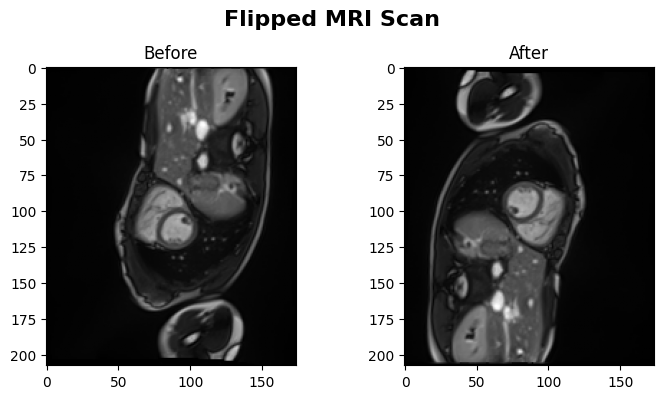

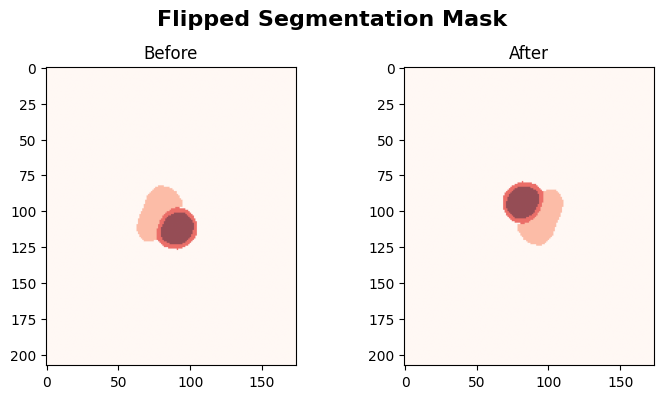

In [40]:
flipped_image = detect_and_correct_flip(processed_image)
flipped_mask = detect_and_correct_flip(processed_mask)
plot_mri_slice(image, flipped_image, cmap=["gray", "gray"], title="Flipped MRI Scan")
plot_mri_slice(mask, flipped_mask, cmap=["Reds", "Reds"], title="Flipped Segmentation Mask", alpha=0.7)

processed_image = flipped_image
processed_mask = flipped_mask

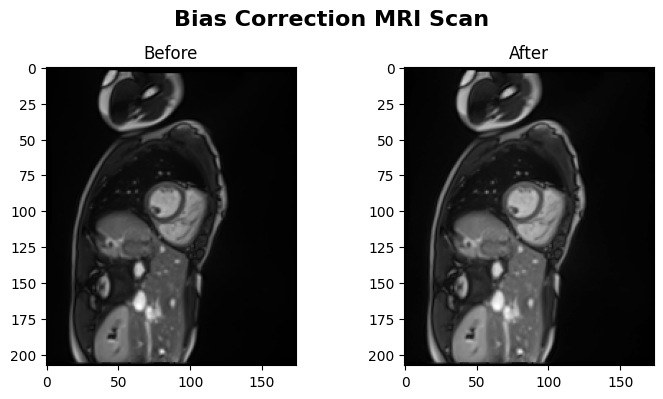

In [41]:
bias_image = log_bias_correction(processed_image)
plot_mri_slice(processed_image, bias_image, cmap=["gray", "gray"], title="Bias Correction MRI Scan")

processed_image = bias_image

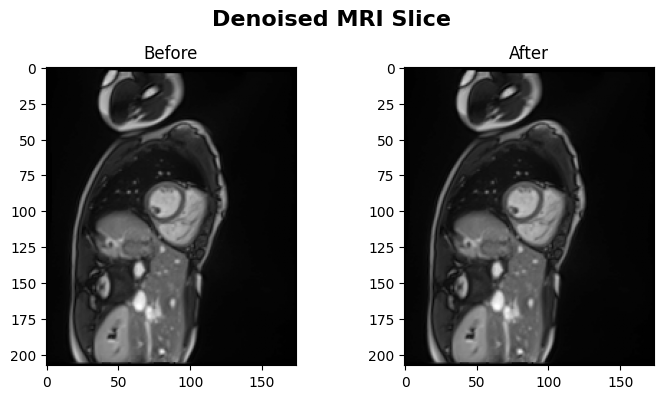

In [42]:
denoise_image = denoise(processed_image, image_metrics_df.loc[sample_idx, 'Std Intensity'])
plot_mri_slice(processed_image, denoise_image, cmap=["gray", "gray"], title="Denoised MRI Slice")
processed_image = denoise_image

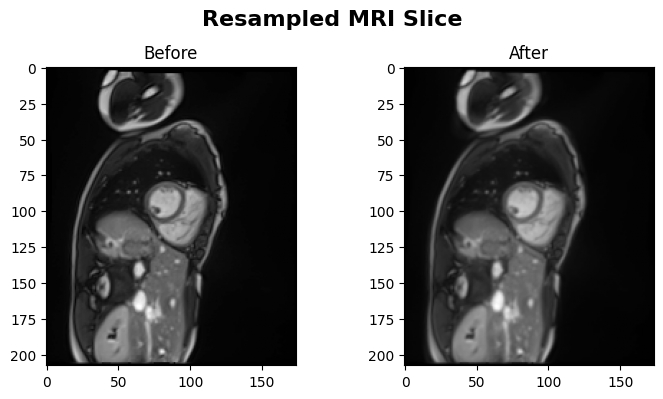

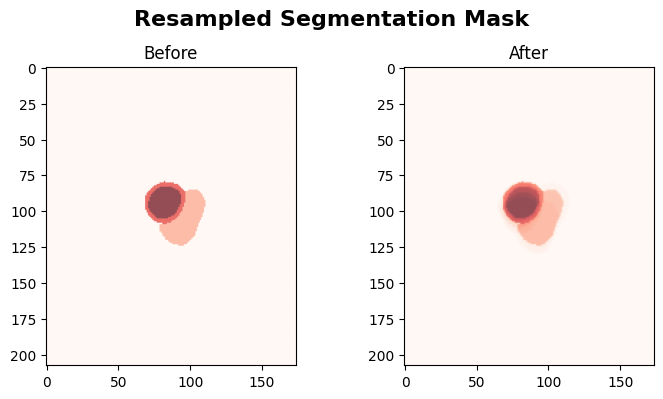

In [43]:
voxel_spacings = np.stack(image_metrics_df["Voxel Spacing"].values)
min_xy_spacing = np.min(voxel_spacings[:, :2], axis=0)  # Take min of X and Y
original_z_spacing = image_metrics_df.loc[sample_idx, "Voxel Spacing"][2]  # Keep Z unchanged
new_spacing = (min_xy_spacing[0], min_xy_spacing[1], original_z_spacing)

resampled_image = resample(processed_image)
resampled_mask = resample(processed_mask, new_spacing=new_spacing, reference_image=resampled_image)

plot_mri_slice(processed_image, resampled_image, cmap=["gray", "gray"], title="Resampled MRI Slice")
plot_mri_slice(processed_mask, resampled_mask, cmap=["Reds", "Reds"], title="Resampled Segmentation Mask", alpha=0.7)

processed_image = resampled_image
processed_mask = resampled_mask

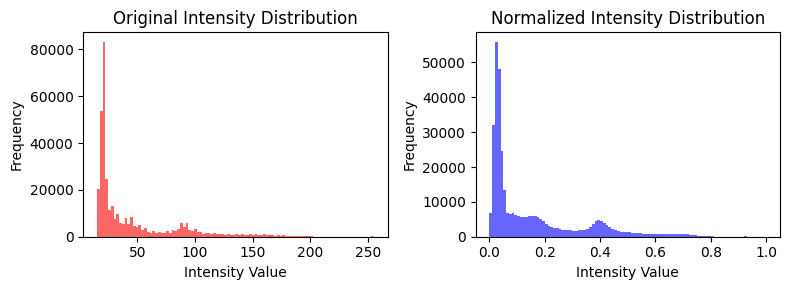

In [44]:
norm_image = (processed_image - np.min(processed_image)) / (np.max(processed_image) - np.min(processed_image))
norm_mask = processed_mask.astype(np.float32)

plot_intensity_histograms(image, norm_image)

processed_image = norm_image
processed_mask = norm_mask

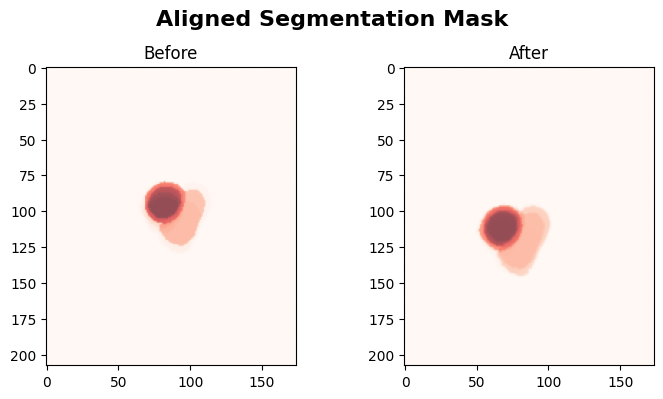

In [45]:
align_image_mask = align_mask(processed_image, processed_mask)
plot_mri_slice(processed_mask, align_image_mask, cmap=["Reds", "Reds"], title="Aligned Segmentation Mask", alpha=0.7)
processed_mask = align_mask